In [1]:
import os
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install tensorflow-gpu==2.0.0-alpha0
!pip uninstall tfp-nightly
!pip install tensorflow-probability
!pip install --upgrade tf-nightly-2.0-preview tfp-nightly

Uninstalling tfp-nightly-0.8.0.dev20190602:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/*
    /usr/local/lib/python3.6/dist-packages/tfp_nightly-0.8.0.dev20190602.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/bijectors/conditional_bijector.py
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/conditional_distribution.py
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/conditional_transformed_distribution.py
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/internal/statistical_testing.py
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/sample_stats.py
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/slice_sampler_utils.py
    /usr/local/lib/python3.6/dist-packages/tensorflow_probability/pyt

In [2]:
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model, Model
tf.__version__

'2.0.0-dev20190602'

In [0]:
(X_clean_train, Y_clean_train), (X_clean_test, Y_clean_test) = tf.keras.datasets.cifar10.load_data()


In [0]:

input_shape = (32,32,3)
encoded_size = 16
base_depth = 32
L2_weight_decay = 2e-5
batch_size = 1000

In [0]:
tfk = tf.keras
tfkl = tf.keras.layers
import tensorflow_probability as tfp
tfd = tfp.distributions
initializer = tf.initializers.VarianceScaling(scale=2.0)

In [0]:
def SampleFromEncoding(mean, sigma):
    t_sigma = tf.sqrt(tf.exp(sigma))
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(mean), mean=0., stddev=1., dtype = tf.float64)
    return mean + t_sigma * epsilon

In [0]:
class VaeConvNet(tf.keras.Model):
    def __init__(self, input_shape = (32,32,3)):
        super(VaeConvNet, self).__init__()  
        self.e_conv1 = tf.keras.layers.Conv2D(filters=3 , kernel_size=2, strides=1, activation=tf.nn.relu, padding='same', name="e-conv1", trainable=True)
        self.e_conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=2, activation=tf.nn.relu, padding='same', name="e-conv2", trainable=True)
        self.e_conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, activation=tf.nn.relu, padding='same', name="e-conv3", trainable=True)
        self.e_conv4 = tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, activation=tf.nn.relu, padding='same', name="e-conv4", trainable=True)
        self.e_dense  = tf.keras.layers.Dense(128, tf.nn.relu, name="e-sdnse", trainable=True)
        self.e_mean  = tf.keras.layers.Dense(encoded_size, tf.nn.softplus, name="e-mean", trainable=True)
        self.e_sigma  = tf.keras.layers.Dense(encoded_size,tf.nn.softplus, name="e-sigma", trainable=True)
        
        self.d_dense = tf.keras.layers.Dense(128, name="d-dense", trainable=True)
        self.d_dense2 = tf.keras.layers.Dense(32*input_shape[0]*input_shape[1]/4, name="d-dense2", trainable=True)
        self.d_convT1 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=1, activation=tf.nn.relu, padding='same', name="d-convT1", trainable=True)
        self.d_convT2 = tf.keras.layers.Conv2DTranspose(filters=32 , kernel_size=2, strides=1, activation=tf.nn.relu, padding='same', name="d-convT2", trainable=True)
        self.d_convT3 = tf.keras.layers.Conv2DTranspose(filters=3  , kernel_size=2, strides=2, activation=tf.nn.relu, padding='valid', name="d-convT3", trainable=True)
        #self.d_conv = tf.keras.layers.Conv2D(filters=3  , kernel_size=2, strides=1, activation=tf.nn.sigmoid, padding='same', name="d-conv", trainable=True)
        
        
    def call(self, x, training=False):
        x = self.e_conv1(x)
        x = self.e_conv2(x)
        x = self.e_conv3(x)
        x = self.e_conv4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.e_dense(x)
        mean = self.e_mean(x)
        sigma = self.e_sigma(x)
        sample = SampleFromEncoding( mean, sigma)
        y = self.d_dense(sample)
        y = self.d_dense2(y)
        y = tf.keras.layers.Reshape(target_shape=(16,16,32), input_shape=(None, encoded_size))(y)
        y = self.d_convT1(y)
        y = self.d_convT2(y)
        y = self.d_convT3(y)
        #y = self.d_conv(y)
        return y, mean, sigma    

In [0]:
def VaeLoss(x, x_reco, mean, sigma):
  reconstruction_term = -tf.reduce_sum(tfp.distributions.MultivariateNormalDiag(
      tf.keras.layers.Flatten()(x_reco), scale_identity_multiplier=0.05).log_prob(tf.keras.layers.Flatten()(x)))
  kl_divergence = 0.5 * tf.reduce_mean(tf.square(mean) + tf.square(sigma) - tf.math.log(1e-8 + tf.square(sigma)) - 1, [1])
  return tf.reduce_mean(reconstruction_term + kl_divergence)

In [0]:
def optimizer_init_fn():
    learning_rate = 0.001
    return tf.keras.optimizers.Adam(learning_rate=learning_rate)

optimizer = optimizer_init_fn()


In [0]:
model     = VaeConvNet()

In [0]:
def Train(model, optimizer, x, num_epochs, batch_size, is_training=False):
    t = 0
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    
    num_batches = tf.shape(x)[0]//batch_size
    for epoch in range(num_epochs):
        
        train_loss.reset_states()
        
        for batch in range(num_batches):
            x_batch_input = x[batch*batch_size : (batch+1)*batch_size]/255
            
            with tf.GradientTape() as tape:
                # Use the model function to build the forward pass.
                y_output, mean, sigma  = model(x_batch_input, training=True)
                loss = VaeLoss(x_batch_input, y_output, mean, sigma )
                
                if is_training:
                  gradients = tape.gradient(loss, model.trainable_variables)
                  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                
            # Update the metrics
            train_loss.update_state(loss)

            if t % 10 == 0:
              template = 'Iteration {}, Epoch {}, Loss: {}'
              print (template.format(t, epoch+1, train_loss.result()) )                   
            t += 1
    

In [ ]:
Train(model, optimizer=optimizer, x=X_clean_train, num_epochs=25, batch_size = batch_size, is_training=True)

In [15]:
Train(model, optimizer=optimizer, x=X_clean_train, num_epochs=10, batch_size = batch_size, is_training=True)

Iteration 0, Epoch 1, Loss: 5029492.0
Iteration 10, Epoch 1, Loss: 4722672.5
Iteration 20, Epoch 1, Loss: 4697304.5
Iteration 30, Epoch 1, Loss: 4686607.0
Iteration 40, Epoch 1, Loss: 4653678.0
Iteration 50, Epoch 2, Loss: 4880903.5
Iteration 60, Epoch 2, Loss: 4583726.0
Iteration 70, Epoch 2, Loss: 4603425.0
Iteration 80, Epoch 2, Loss: 4616446.0
Iteration 90, Epoch 2, Loss: 4597495.5
Iteration 100, Epoch 3, Loss: 4873375.0
Iteration 110, Epoch 3, Loss: 4574323.0
Iteration 120, Epoch 3, Loss: 4594009.5
Iteration 130, Epoch 3, Loss: 4606757.5
Iteration 140, Epoch 3, Loss: 4587775.0
Iteration 150, Epoch 4, Loss: 4864523.5
Iteration 160, Epoch 4, Loss: 4563099.0
Iteration 170, Epoch 4, Loss: 4583357.5
Iteration 180, Epoch 4, Loss: 4596370.0
Iteration 190, Epoch 4, Loss: 4577820.5
Iteration 200, Epoch 5, Loss: 4854783.0
Iteration 210, Epoch 5, Loss: 4553606.0
Iteration 220, Epoch 5, Loss: 4573682.5
Iteration 230, Epoch 5, Loss: 4586367.0
Iteration 240, Epoch 5, Loss: 4567557.5
Iteration 2

In [17]:
Train(model, optimizer=optimizer, x=X_clean_train, num_epochs=10, batch_size = batch_size, is_training=True)

Iteration 0, Epoch 1, Loss: 4795487.5
Iteration 10, Epoch 1, Loss: 4516942.0
Iteration 20, Epoch 1, Loss: 4525826.5
Iteration 30, Epoch 1, Loss: 4532755.0
Iteration 40, Epoch 1, Loss: 4511228.0
Iteration 50, Epoch 2, Loss: 4771861.0
Iteration 60, Epoch 2, Loss: 4475030.0
Iteration 70, Epoch 2, Loss: 4496811.0
Iteration 80, Epoch 2, Loss: 4510669.5
Iteration 90, Epoch 2, Loss: 4493101.0
Iteration 100, Epoch 3, Loss: 4768635.5
Iteration 110, Epoch 3, Loss: 4471935.5
Iteration 120, Epoch 3, Loss: 4493577.5
Iteration 130, Epoch 3, Loss: 4507244.0
Iteration 140, Epoch 3, Loss: 4489442.5
Iteration 150, Epoch 4, Loss: 4765326.5
Iteration 160, Epoch 4, Loss: 4467712.0
Iteration 170, Epoch 4, Loss: 4489090.5
Iteration 180, Epoch 4, Loss: 4502918.0
Iteration 190, Epoch 4, Loss: 4485296.5
Iteration 200, Epoch 5, Loss: 4762504.5
Iteration 210, Epoch 5, Loss: 4463289.5
Iteration 220, Epoch 5, Loss: 4485148.0
Iteration 230, Epoch 5, Loss: 4499182.5
Iteration 240, Epoch 5, Loss: 4481353.0
Iteration 2

In [19]:
Train(model, optimizer=optimizer, x=X_clean_train, num_epochs=10, batch_size = batch_size, is_training=True)

Iteration 0, Epoch 1, Loss: 4738730.0
Iteration 10, Epoch 1, Loss: 4432672.5
Iteration 20, Epoch 1, Loss: 4451177.5
Iteration 30, Epoch 1, Loss: 4462854.5
Iteration 40, Epoch 1, Loss: 4443687.0
Iteration 50, Epoch 2, Loss: 4718017.5
Iteration 60, Epoch 2, Loss: 4421271.5
Iteration 70, Epoch 2, Loss: 4442033.0
Iteration 80, Epoch 2, Loss: 4455782.5
Iteration 90, Epoch 2, Loss: 4438396.5
Iteration 100, Epoch 3, Loss: 4719292.5
Iteration 110, Epoch 3, Loss: 4419661.5
Iteration 120, Epoch 3, Loss: 4440582.0
Iteration 130, Epoch 3, Loss: 4454466.0
Iteration 140, Epoch 3, Loss: 4436898.5
Iteration 150, Epoch 4, Loss: 4716809.0
Iteration 160, Epoch 4, Loss: 4417225.5
Iteration 170, Epoch 4, Loss: 4438447.0
Iteration 180, Epoch 4, Loss: 4452729.0
Iteration 190, Epoch 4, Loss: 4435500.0
Iteration 200, Epoch 5, Loss: 4714538.5
Iteration 210, Epoch 5, Loss: 4414987.5
Iteration 220, Epoch 5, Loss: 4436769.5
Iteration 230, Epoch 5, Loss: 4451037.0
Iteration 240, Epoch 5, Loss: 4434036.5
Iteration 2

In [30]:
Train(model, optimizer=optimizer, x=X_clean_train, num_epochs=10, batch_size = batch_size, is_training=True)

Iteration 0, Epoch 1, Loss: 4706355.0
Iteration 10, Epoch 1, Loss: 4408084.5
Iteration 20, Epoch 1, Loss: 4429587.0
Iteration 30, Epoch 1, Loss: 4444014.5
Iteration 40, Epoch 1, Loss: 4426845.0
Iteration 50, Epoch 2, Loss: 4706973.0
Iteration 60, Epoch 2, Loss: 4407222.5
Iteration 70, Epoch 2, Loss: 4428185.0
Iteration 80, Epoch 2, Loss: 4442463.5
Iteration 90, Epoch 2, Loss: 4425146.0
Iteration 100, Epoch 3, Loss: 4706651.5
Iteration 110, Epoch 3, Loss: 4406599.5
Iteration 120, Epoch 3, Loss: 4427624.0
Iteration 130, Epoch 3, Loss: 4441759.0
Iteration 140, Epoch 3, Loss: 4424533.5
Iteration 150, Epoch 4, Loss: 4704949.5
Iteration 160, Epoch 4, Loss: 4404856.5
Iteration 170, Epoch 4, Loss: 4425956.0
Iteration 180, Epoch 4, Loss: 4440194.0
Iteration 190, Epoch 4, Loss: 4422988.5
Iteration 200, Epoch 5, Loss: 4705428.0
Iteration 210, Epoch 5, Loss: 4402840.0
Iteration 220, Epoch 5, Loss: 4424338.5
Iteration 230, Epoch 5, Loss: 4438575.5
Iteration 240, Epoch 5, Loss: 4421324.5
Iteration 2

In [32]:
Train(model, optimizer=optimizer, x=X_clean_train, num_epochs=15, batch_size = batch_size, is_training=True)

Iteration 0, Epoch 1, Loss: 4697745.5
Iteration 10, Epoch 1, Loss: 4395869.0
Iteration 20, Epoch 1, Loss: 4416639.0
Iteration 30, Epoch 1, Loss: 4430612.0
Iteration 40, Epoch 1, Loss: 4413318.0
Iteration 50, Epoch 2, Loss: 4690193.5
Iteration 60, Epoch 2, Loss: 4391524.5
Iteration 70, Epoch 2, Loss: 4413672.5
Iteration 80, Epoch 2, Loss: 4428306.0
Iteration 90, Epoch 2, Loss: 4411500.0
Iteration 100, Epoch 3, Loss: 4693664.5
Iteration 110, Epoch 3, Loss: 4391505.5
Iteration 120, Epoch 3, Loss: 4413021.0
Iteration 130, Epoch 3, Loss: 4427709.0
Iteration 140, Epoch 3, Loss: 4410805.5
Iteration 150, Epoch 4, Loss: 4689900.0
Iteration 160, Epoch 4, Loss: 4392024.5
Iteration 170, Epoch 4, Loss: 4413300.0
Iteration 180, Epoch 4, Loss: 4427620.5
Iteration 190, Epoch 4, Loss: 4410627.0
Iteration 200, Epoch 5, Loss: 4691763.0
Iteration 210, Epoch 5, Loss: 4391096.0
Iteration 220, Epoch 5, Loss: 4412045.5
Iteration 230, Epoch 5, Loss: 4426632.5
Iteration 240, Epoch 5, Loss: 4409722.0
Iteration 2

In [0]:
# model.load_weights('vae.h5') 

In [0]:
x_reco, mean, sigma  = model(X_clean_test[0:batch_size]/255, training=False)

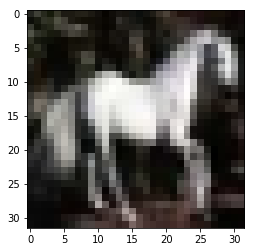

In [49]:
plt.imshow(X_clean_test[13])

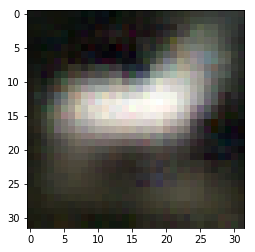

In [50]:
plt.imshow(np.clip(x_reco[13]*255, 0, 255).astype(int))

In [51]:
model.summary()

Model: "vae_conv_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e-conv1 (Conv2D)             multiple                  39        
_________________________________________________________________
e-conv2 (Conv2D)             multiple                  416       
_________________________________________________________________
e-conv3 (Conv2D)             multiple                  4128      
_________________________________________________________________
e-conv4 (Conv2D)             multiple                  4128      
_________________________________________________________________
e-sdnse (Dense)              multiple                  1048704   
_________________________________________________________________
e-mean (Dense)               multiple                  2064      
_________________________________________________________________
e-sigma (Dense)              multiple                 

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model.save_weights('vae.h5')    
model_file = drive.CreateFile({'title' : 'vae.h5'})
model_file.SetContentFile('vae.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

In [ ]:
class VaeDetectorNet(tf.keras.Model):
    def __init__(self, input_shape = (32,32,3)):
        super(VaeDecodervNet, self).__init__() 
        self.dense1 = tf.keras.layers.Dense(256, name="d-dense1", activation=tf.nn.leaky_relu,kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(64, name="d-dense2", activation=tf.nn.leaky_relu,kernel_initializer=initializer)
        self.sigmoid = tf.keras.layers.Dense(1, name="d-sigmoid", activation='sigmoid',kernel_initializer=tf.initializers.GlorotNormal())
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.sigmoid(x)   

In [ ]:
# CNN based detector model
def encode_model_init_fn():
    input_shape = (32, 32, 3)
    channel_1, channel_2, channel_3, channel_4, num_classes = 32, 64, 96, 128, 10
    BN_decay        = 0.99
    BN_epsilon      = 1.e-5
    L2_weight_decay = 2e-5
    droput_rate     = 0.11
    
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Conv2D(input_shape=input_shape, kernel_size=(3,3), filters=channel_1, activation='relu', padding='same', kernel_initializer=initializer, 
                             kernel_regularizer=tf.keras.regularizers.l2(L2_weight_decay),
                             bias_regularizer=tf.keras.regularizers.l2(L2_weight_decay)),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=BN_decay, epsilon=BN_epsilon),
        #tf.keras.layers.Dropout(droput_rate),
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=channel_2, activation='relu', padding='same', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l2(L2_weight_decay),
                             bias_regularizer=tf.keras.regularizers.l2(L2_weight_decay)),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=BN_decay, epsilon=BN_epsilon),
        tf.keras.layers.Dropout(droput_rate),
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=channel_3, activation='relu', padding='same', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l2(L2_weight_decay),
                             bias_regularizer=tf.keras.regularizers.l2(L2_weight_decay)),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=BN_decay, epsilon=BN_epsilon),
        tf.keras.layers.Dropout(droput_rate),
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=channel_4, activation='relu', padding='same', kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l2(L2_weight_decay),
                             bias_regularizer=tf.keras.regularizers.l2(L2_weight_decay)),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model


In [0]:
learning_rate = 5e-3
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.9, nesterov=True)

In [0]:
model = model_init_fn()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.binary_accuracy])



In [0]:
print(tf.shape(X_clean_train_correct))
print(tf.shape(X_clean_test_correct))
X_d_trian = tf.concat( [X_clean_train_correct, X_clean_test_correct], axis = 0)
print(tf.shape(X_d_trian))
#Y_d_trian = tf.concat(Y_clean_train_correct, Y_clean_test_correct)
Y_d_train = tf.ones(tf.shape(X_d_trian)[0])

tf.Tensor([47460    32    32     3], shape=(4,), dtype=int32)
tf.Tensor([8256   32   32    3], shape=(4,), dtype=int32)
tf.Tensor([55716    32    32     3], shape=(4,), dtype=int32)


In [ ]:
model.fit(X_d_trian, Y_d_train, batch_size=64, epochs=1) #, validation_data=(X_val, y_val))

In [0]:
model.evaluate(X_test, y_test)